In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 
import random 
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold


from sklearn.metrics import log_loss

path = Path('/kaggle/input/tabular-playground-series-nov-2022/')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
submission = pd.read_csv(path / 'sample_submission.csv', index_col='id')
labels = pd.read_csv(path / 'train_labels.csv', index_col='id')

# the ids of the submission rows (useful later)
sub_ids = submission.index

# the ids of the labeled rows (useful later)
gt_ids = labels.index 

# list of files in the submission folder
subs = sorted(os.listdir(path / 'submission_files'))

**Downloading all data to X_train dataframe**

In [3]:
s0 = pd.read_csv(path / 'submission_files' / subs[0], index_col='id')

X_train = np.zeros((s0.shape[0], len(subs)))
for i, name in enumerate(subs):
    sub = pd.read_csv(path / 'submission_files' / name, index_col='id')
    X_train[:,i] = sub.pred.values
X_train = pd.DataFrame(X_train, columns=subs)

In [4]:
X_train.head(10)

,0.6222863195.csv,0.6223807245.csv,0.6225426578.csv,0.6247722291.csv,0.6253455681.csv,0.6254850917.csv,0.6255093621.csv,0.6260141578.csv,0.6263493693.csv,0.6272779211.csv,...,0.7519100517.csv,0.7519556278.csv,0.7520219713.csv,0.7521219579.csv,0.7522329272.csv,0.7523602310.csv,0.7526089604.csv,0.7526999358.csv,0.7551167673.csv,0.7575039918.csv
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.769207,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.640052,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.812841,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.824703,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.934803,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934
5,0.831414,0.598125,0.276116,0.525463,0.734328,0.520369,0.081827,0.532379,0.821128,0.904294,...,0.908995,0.823174,0.912174,0.930805,0.571190,0.926527,0.889757,0.939157,0.908295,0.935
6,0.716171,0.424948,0.692054,0.328312,0.622229,0.687056,0.502608,0.501735,0.611488,0.580623,...,0.779942,0.716931,0.689678,0.661001,0.856190,0.709248,0.626589,0.575874,0.726107,0.434
7,0.953687,0.934748,0.942298,0.858528,0.794114,0.846232,0.841102,0.951427,0.775044,0.941849,...,0.933843,0.912999,0.930557,0.946958,0.985094,0.970721,0.872210,0.971870,0.933964,0.837
8,0.427233,0.372343,0.814237,0.555591,0.533184,0.609211,0.552825,0.402674,0.509153,0.569622,...,0.587888,0.681688,0.661960,0.608619,0.667168,0.617447,0.659957,0.808672,0.628330,1.000
9,0.619906,0.719119,0.685702,0.640120,0.659804,0.705191,0.497439,0.563905,0.543911,0.529731,...,0.808328,0.776024,0.778681,0.821828,0.814284,0.808427,0.753920,0.816997,0.671402,0.658


**Dropping bad datasets**
or clipping 'bad' values
and dropping columns with inverted predictions

In [5]:
X_train = X_train.clip(0.0000001, 0.99999999)

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score
aucs = {}
acc = {}

for column in X_train.columns:
    aucs[column] = roc_auc_score(labels, X_train[:20000][column])
    acc[column] = accuracy_score(labels, np.round(X_train[:20000][column]))
    
auc_df = pd.DataFrame.from_dict(aucs, orient='index').squeeze().rename('AUC')
acc_df = pd.DataFrame.from_dict(acc, orient='index').squeeze().rename('ACC')
print('Models with flipped probabilites: ')
print(auc_df[auc_df.lt(0.5)]) 
print(acc_df[acc_df.lt(0.5)]) 

Models with flipped probabilites: 
0.6932630537.csv    0.489735
0.6952756302.csv    0.437338
0.6962369747.csv    0.486196
0.7069486042.csv    0.474238
0.7168457192.csv    0.495189
0.7215003044.csv    0.495341
0.7366981883.csv    0.495000
0.7450339370.csv    0.483432
Name: AUC, dtype: float64
0.6885896550.csv    0.47435
0.6952756302.csv    0.46235
0.6962369747.csv    0.48970
0.6982037018.csv    0.49355
0.6999220673.csv    0.49205
0.7069486042.csv    0.44600
0.7168457192.csv    0.49510
0.7215003044.csv    0.49995
0.7246302099.csv    0.49465
0.7366981883.csv    0.49815
0.7395879372.csv    0.49085
0.7450339370.csv    0.49960
Name: ACC, dtype: float64


<AxesSubplot:ylabel='Frequency'>

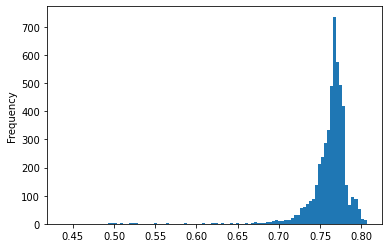

In [7]:
auc_df.plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

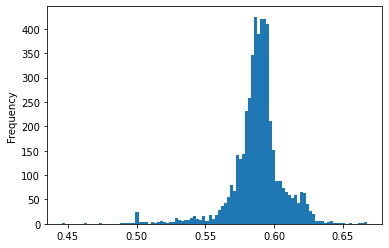

In [8]:
acc_df.plot.hist(bins=100)

In [9]:
drop_cols1 = list(auc_df[auc_df.lt(0.5)].index)
drop_cols2 = list(acc_df[acc_df.lt(0.5)].index)

for item in drop_cols1:
    if item in drop_cols2:
        drop_cols2.remove(item)

# for column in drop_cols:
#     X_train[column] = 1 - X_train[column]
X_train = X_train.drop(drop_cols1, axis=1)
X_train = X_train.drop(drop_cols2, axis=1)

In [10]:
# X_train1 = X_train.copy()

In [11]:
X_train_np = np.array(X_train)
X_train = pd.DataFrame(X_train_np ** 0.9)
X_train

,0,1,2,3,4,5,6,7,8,9,...,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986
0,0.734120,0.817138,0.865657,0.571600,0.654067,0.730984,0.539201,0.662792,0.670668,0.694194,...,0.789658,0.772121,0.691163,0.762002,0.838624,0.771425,0.753153,0.880235,0.768080,0.806078
1,0.490318,0.403160,0.600656,0.393205,0.549197,0.616384,0.492092,0.275259,0.508967,0.557363,...,0.669258,0.812576,0.745252,0.822072,0.650949,0.756688,0.833628,0.831136,0.629865,0.581017
2,0.702491,0.856844,0.818064,0.560162,0.718018,0.739782,0.679560,0.640081,0.717203,0.640904,...,0.829860,0.799493,0.878236,0.844228,0.783930,0.820705,0.824391,0.905946,0.869209,0.694566
3,0.517569,0.609731,0.709573,0.575618,0.659874,0.692235,0.451552,0.543800,0.561037,0.616807,...,0.840752,0.817774,0.818172,0.740886,0.635024,0.733340,0.859203,0.866723,0.864528,0.652246
4,0.961522,0.918929,0.925272,0.886294,0.806627,0.867835,0.858296,0.888357,0.837471,0.921397,...,0.941127,0.909669,0.964750,0.915022,0.965047,0.941856,0.900211,0.980634,0.958215,0.940399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.421098,0.327181,0.519748,0.319370,0.452388,0.500387,0.428870,0.265796,0.492746,0.362279,...,0.595289,0.682702,0.645228,0.637918,0.510778,0.611172,0.616787,0.576424,0.576288,0.303664
39996,0.391238,0.338813,0.626544,0.384260,0.525226,0.541960,0.252278,0.329666,0.508316,0.354420,...,0.616950,0.650530,0.665349,0.617039,0.703944,0.647612,0.638319,0.610399,0.621899,0.748694
39997,0.610145,0.700885,0.781540,0.519815,0.708856,0.691729,0.486276,0.571734,0.608193,0.638065,...,0.762138,0.781615,0.794502,0.833978,0.820379,0.832164,0.736838,0.877077,0.806058,0.604862
39998,0.736929,0.810337,0.824577,0.827168,0.682519,0.694677,0.533304,0.954952,0.556082,0.579852,...,0.723820,0.737695,0.806053,0.797998,0.830369,0.800591,0.648834,0.794987,0.694007,0.670150


In [12]:
X_train['mean'] = X_train.mean(axis=1)
X_train['std'] = X_train.std(axis=1)

# X_train['min_pred'] = X_train1.min(axis = 1)
# X_train['max_pred'] = X_train1.max(axis = 1)
# X_train['median_pred'] = X_train1.median(axis = 1)
# X_train['var_pred'] = X_train1.var(axis = 1)
# X_train['q1_pred'] = X_train1.quantile(q=0.25, axis = 1)
# X_train['q3_pred'] = X_train1.quantile(q=0.75, axis = 1)
# X_train['skew_pred'] = X_train1.skew(axis = 1)
# X_train['kurtosis_pred'] = X_train1.kurtosis(axis = 1)

# X_train['var_pred'] = X_train['var_pred'] / X_train['var_pred'].max()
# X_train['skew_pred'] = X_train['skew_pred'] / X_train['skew_pred'].max()
# X_train['kurtosis_pred'] = X_train['kurtosis_pred'] / X_train['kurtosis_pred'].max()

In [13]:
# X_train = X_train.loc[:, X_train.max()<=1]
# X_train = X_train.loc[:, X_train.min()>=0]

In [14]:
X_train.shape

(40000, 4989)

**PCA**

Thanks to @infrarosso for PCA! Please, upvote his notebook!
https://www.kaggle.com/code/infrarosso/tps-nov-2022-eda-lgbm-stacking
(link for upvoting)

In [15]:
VARIANCE_TH = 0.98

pca = PCA()
pca_samples = pca.fit_transform(X_train)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total <= VARIANCE_TH:
    current_variance += pca.explained_variance_[k]
    k = k + 1
print(F"{VARIANCE_TH*100:.0f}% explained variance with {k}/{len(X_train.columns)} features")

98% explained variance with 152/4989 features


In [16]:
pca=PCA(n_components=k)
X_train_reduced = pd.DataFrame(pca.fit_transform(X_train))
X_train_reduced.shape

(40000, 152)

In [17]:
# X_train_reduced = X_train

In [18]:
X = X_train_reduced[0:20000]
X_test = X_train_reduced[20000:]
y = labels

In [19]:
from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

**Simple Keras model**
with 
- Batchnormalization 
- Dropout
- EarlyStopping
- Learning rate exponential decay

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, Concatenate, Add, BatchNormalization, LeakyReLU

# model = keras.Sequential([
# #     layers.Dense(1024), 
# #     layers.LeakyReLU(alpha=0.3),
# # #     layers.BatchNormalization(),
# #     layers.Dropout(rate=0.3),
# #     layers.Dense(512), 
# #     layers.LeakyReLU(alpha=0.3),
# # #     layers.BatchNormalization(),
# #     layers.Dropout(rate=0.3),
#     layers.Dense(256), 
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=0.1),
#     layers.Dense(128),
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=0.1),
#     layers.Dense(64),
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=0.1),
#     layers.Dense(32),
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=0.1),
#     layers.Dense(16),
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=0.1),
#     layers.Dense(8),
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=0.1),
#     layers.Dense(4),
#     layers.LeakyReLU(alpha=0.3),
#     layers.Dropout(rate=0.1),
#     layers.Dense(2),
#     layers.LeakyReLU(alpha=0.3),
#     layers.Dense(1, activation='sigmoid'),
# ])


# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#                     initial_learning_rate=0.0001,
#                     decay_steps=1000,
#                     decay_rate=0.9)
# opt = keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(
#     optimizer=opt,
#     loss='binary_crossentropy',
#     metrics=['binary_accuracy'],
# )
# early_stopping = keras.callbacks.EarlyStopping(
#     patience=30,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

def test_nn(lr, sc=2, dec_r=0.65, bs=128, dr=0.2):
    
    input_ = Input(shape = X_train.shape[1])
    d0 = Dense(1024 * sc // 5 + 1)(input_)
    a0 = LeakyReLU()(d0)
    dr0 = Dropout(rate=dr)(a0)
    d01 = Dense(512 * sc // 5 + 1)(dr0)
    a01 = LeakyReLU()(d01)
    dr01 = Dropout(rate=dr)(a01)
    d1 = Dense(256 * sc // 5 + 1)(dr01)
    a1 = LeakyReLU()(d1)
    dr1 = Dropout(rate=dr)(a1)
    d2 = Dense(128 * sc // 5 + 1)(dr1)
    a2 = LeakyReLU()(d2)
    dr2 = Dropout(rate=dr)(a2)
    d3 = Dense(64 * sc // 5 + 1)(dr2)
    a3 = LeakyReLU()(d3)
    dr3 = Dropout(rate=dr)(a3)
    d4 = Dense(32 * sc // 5 + 1)(dr3)
    a4 = LeakyReLU()(d4)
    dr4 = Dropout(rate=dr)(a4)
    d5 = Dense(16 * sc // 5 + 1)(dr4)
    a5 = LeakyReLU()(d5)
    dr5 = Dropout(rate=dr)(a5)
#     concat1 = Concatenate()([dr5, input_])
    d6 = Dense(8 * sc // 5 + 1)(dr5)
    a6 = LeakyReLU()(d6)
    dr6 = Dropout(rate=dr)(a6)
#     concat2 = Concatenate()([dr6, input_])
    d7 = Dense(4)(dr6)
    a7 = LeakyReLU()(d7)
    dr7 = Dropout(rate=dr)(a7)
    concat3 = Concatenate()([dr7, input_])
    d8 = Dense(2)(concat3)
    a8 = LeakyReLU()(d8)
    dr8 = Dropout(rate=dr)(a8)
    out = Dense(1, activation='sigmoid')(dr8)
    
    model1 = Model(inputs=input_, outputs=out)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=lr,
                    decay_steps=1000,
                    decay_rate=dec_r)
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#     opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
    opt = keras.optimizers.Ftrl(learning_rate=lr_schedule)

    model1.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
    )
    early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
    )
    
    history = model1.fit(
          X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=bs,
          epochs=300,
          callbacks=[early_stopping],
          verbose=0,
         )
    
    
    return log_loss(labels, model1.predict(X))

In [51]:
# sc_val = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# dr_val = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# lr_val = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
# dec_r_val = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
# bs_val = [32, 64, 128, 256, 512, 1024, 2048]
# res_test = []

# for val in lr_val:
#     res_test.append(test_nn(val))
#     print('scale = ',  val, ',  result = ', res_test[-1])

scale =  1e-05 ,  result =  0.6932766159117222
scale =  5e-05 ,  result =  0.6940796726524829
scale =  0.0001 ,  result =  0.6933589877188205
scale =  0.0005 ,  result =  0.6932530830830336
scale =  0.001 ,  result =  0.6915326069712638
scale =  0.005 ,  result =  0.606089263746515
scale =  0.01 ,  result =  0.5675499840654433


In [52]:
# test_nn(0.5)

0.5233613361767144

In [45]:
# res_test

[0.5343180115364657,
 0.5245505342843942,
 0.5254674781319977,
 0.5272080251278821,
 0.534142530922393,
 0.5361577436995169,
 0.5241544840319547,
 0.5241106417487142,
 0.5394537482756209]

In [ ]:
# stop

In [ ]:
n_folds = 30

k_fold = StratifiedKFold(n_splits=n_folds, random_state=43, shuffle=True)

preds = []

# best_res = 1

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    lr=0.5
    sc=2
    dec_r=0.65
    bs=128
    dr=0.2

    input_ = Input(shape = X_train.shape[1])
    d0 = Dense(1024 * sc // 5 + 1)(input_)
    a0 = LeakyReLU()(d0)
    dr0 = Dropout(rate=dr)(a0)
    d01 = Dense(512 * sc // 5 + 1)(dr0)
    a01 = LeakyReLU()(d01)
    dr01 = Dropout(rate=dr)(a01)
    d1 = Dense(256 * sc // 5 + 1)(dr01)
    a1 = LeakyReLU()(d1)
    dr1 = Dropout(rate=dr)(a1)
    d2 = Dense(128 * sc // 5 + 1)(dr1)
    a2 = LeakyReLU()(d2)
    dr2 = Dropout(rate=dr)(a2)
    d3 = Dense(64 * sc // 5 + 1)(dr2)
    a3 = LeakyReLU()(d3)
    dr3 = Dropout(rate=dr)(a3)
    d4 = Dense(32 * sc // 5 + 1)(dr3)
    a4 = LeakyReLU()(d4)
    dr4 = Dropout(rate=dr)(a4)
    d5 = Dense(16 * sc // 5 + 1)(dr4)
    a5 = LeakyReLU()(d5)
    dr5 = Dropout(rate=dr)(a5)
#     concat1 = Concatenate()([dr5, input_])
    d6 = Dense(8 * sc // 5 + 1)(dr5)
    a6 = LeakyReLU()(d6)
    dr6 = Dropout(rate=dr)(a6)
#     concat2 = Concatenate()([dr6, input_])
    d7 = Dense(4)(dr6)
    a7 = LeakyReLU()(d7)
    dr7 = Dropout(rate=dr)(a7)
    concat3 = Concatenate()([dr7, input_])
    d8 = Dense(2)(concat3)
    a8 = LeakyReLU()(d8)
    dr8 = Dropout(rate=dr)(a8)
    out = Dense(1, activation='sigmoid')(dr8)
    
    model1 = Model(inputs=input_, outputs=out)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=lr,
                    decay_steps=1000,
                    decay_rate=dec_r)
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#     opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
    opt = keras.optimizers.Ftrl(learning_rate=lr_schedule)

    model1.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
    )
    early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
    )
    
    history = model1.fit(
          X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2048,
          epochs=300,
          callbacks=[early_stopping],
          verbose=1,
         )
    preds.append(model1.predict(X_test))
    print('--------------------------------------------------------')
    history_df = pd.DataFrame(history.history)
    history_df.loc[1:, ['loss', 'val_loss']].plot()
    history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()
    print('--------------------------------------------------------')
    print("Logloss valid = {}".format(log_loss(y_valid, model1.predict(X_valid))))
    res = log_loss(labels, model1.predict(X))
    print("Logloss full = {}".format(res))
    
#     if res < best_res:
#         best_res = res
#         model = model1

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_valid, y_valid),
#     batch_size=256,
#     epochs=100,
#     callbacks=[early_stopping],
#     verbose=1,
# )

In [ ]:
# history_df = pd.DataFrame(history.history)

# history_df.loc[1:, ['loss', 'val_loss']].plot()
# history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state=43)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_valid, y_valid),
#     batch_size=256,
#     epochs=100,
#     callbacks=[early_stopping],
#     verbose=1,
# )

In [ ]:
# history_df = pd.DataFrame(history.history)

# history_df.loc[1:, ['loss', 'val_loss']].plot()
# history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
score = log_loss(labels, model1.predict(X))
score

**Making prediction**

In [ ]:
preds

In [ ]:
pred = np.average(np.array(preds),axis=0)
# pred = model.predict(X_test)
pred

In [ ]:
pr = pd.DataFrame(pred)
pr.plot.hist(bins=100)

In [ ]:
# pred = model.predict(X_test)

In [ ]:
# pred

In [ ]:
submission['pred'] = pred
submission

In [ ]:
submission.to_csv('submission.csv')